In [57]:
import pyspark
from pyspark.sql import SparkSession
import pandas as pd
import datetime
import pyspark.sql.functions as f
from pyspark.sql.window import Window
import numpy as np
from math import log
from pyspark.sql.types import *
from pyspark.sql.functions import desc, col, column,sqrt,isnan, when, count,date_format,to_timestamp
from math import log
from pyspark.sql.functions import udf,desc
from datetime import datetime
import seaborn as sns

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD, LinearRegressionModel
from pyspark.ml.regression import RandomForestRegressor, RandomForestRegressionModel, DecisionTreeRegressor
from pyspark.ml.regression import GBTRegressor
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pyspark.mllib.util import MLUtils
from pyspark.sql.functions import percent_rank
!pip install mlflow
import mlflow.sklearn
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator
import warnings
warnings.filterwarnings('ignore')


In [58]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnan
import yfinance as yf

# Create a Spark session
spark = SparkSession.builder.appName('APPL_Project').getOrCreate()

# Retrieve data using yfinance
data = yf.download('AAPL', start='2012-01-01', end='2023-01-01')

# Convert the pandas DataFrame to a Spark DataFrame
df_AP = spark.createDataFrame(data.reset_index())

# Extract the column names exactly as they appear in the DataFrame
columns_to_keep = ["('Date', '')", "('Adj Close', 'AAPL')"]

# Use the exact column names to select the necessary columns
df_AP = df_AP.select([col(c) for c in columns_to_keep])

# Rename the remaining columns for consistency
df_AP = df_AP.withColumnRenamed("('Date', '')", 'Date') \
             .withColumnRenamed("('Adj Close', 'AAPL')", 'Adj Close')

# Cast 'Adj Close' to double
df_AP = df_AP.withColumn('Adj Close', col('Adj Close').cast('double'))

# Check for null/NaN values in 'Adj Close'
df_AP.select([count(when(isnan('Adj Close') | col('Adj Close').isNull(), 'Adj Close')).alias('Adj Close')]).show()


[*********************100%***********************]  1 of 1 completed


+---------+
|Adj Close|
+---------+
|        0|
+---------+



In [59]:
df_AP.show()


+-------------------+------------------+
|               Date|         Adj Close|
+-------------------+------------------+
|2012-01-03 00:00:00|12.388999938964844|
|2012-01-04 00:00:00|12.455575942993164|
|2012-01-05 00:00:00|12.593856811523438|
|2012-01-06 00:00:00|12.725512504577637|
|2012-01-09 00:00:00|12.705324172973633|
|2012-01-10 00:00:00| 12.75082015991211|
|2012-01-11 00:00:00|12.730030059814453|
|2012-01-12 00:00:00|12.695080757141113|
|2012-01-13 00:00:00| 12.64748477935791|
|2012-01-17 00:00:00| 12.79480266571045|
|2012-01-18 00:00:00|12.927666664123535|
|2012-01-19 00:00:00|12.886689186096191|
|2012-01-20 00:00:00|12.662246704101562|
|2012-01-23 00:00:00|12.876444816589355|
|2012-01-24 00:00:00|12.665559768676758|
|2012-01-25 00:00:00| 13.45638370513916|
|2012-01-26 00:00:00| 13.39522933959961|
|2012-01-27 00:00:00|13.475061416625977|
|2012-01-30 00:00:00|13.647693634033203|
|2012-01-31 00:00:00|13.752227783203125|
+-------------------+------------------+
only showing top

In [60]:
# Reading the volatility index data VIX from the uploaded file
df_VX = spark.read.csv('/content/VIXCLS.csv', inferSchema=True, header=True)

# Rename the 'DATE' column to avoid confusion when joining with other DataFrames
df_VX = df_VX.withColumnRenamed('DATE', 'DATEV')

# Checking if there are any null/NaN values in the 'VIXCLS' column
df_VX.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in ["VIXCLS"]]).show()



+------+
|VIXCLS|
+------+
|     0|
+------+



In [61]:


# Reading the US bond yield data from the uploaded file
df_BY = spark.read.csv('/content/BAMLH0A0HYM2 (1).csv', inferSchema=True, header=True)

# Rename the 'DATE' column to avoid confusion when joining with other DataFrames
df_BY = df_BY.withColumnRenamed('DATE', 'DATEBY')

# Check if there are any null/NaN values in the 'BAMLH0A0HYM2' column
df_BY.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in ["BAMLH0A0HYM2"]]).show()


+------------+
|BAMLH0A0HYM2|
+------------+
|           0|
+------------+



In [62]:

# Getting statistical information about the bond yiled data
df_BY.describe().show()
# We have some empty values which were fill in as ., that probably a weekend day where stock market is functioning
(df_BY.filter(df_BY['BAMLH0A0HYM2'] =='.')).describe().show()
# Clean the data
df_BY = df_BY.filter(df_BY['BAMLH0A0HYM2'] != '.')
# Chnage the column type format to double to avoide any error in the data as intial reading is string
df_BY = df_BY.withColumn('BAMLH0A0HYM2',f.col('BAMLH0A0HYM2').cast('double'))
df_BY.describe().show()

+-------+------------------+
|summary|      BAMLH0A0HYM2|
+-------+------------------+
|  count|              3169|
|   mean| 4.587923322683712|
| stddev|1.1381839360536812|
|    min|                 .|
|    max|              9.82|
+-------+------------------+

+-------+------------+
|summary|BAMLH0A0HYM2|
+-------+------------+
|  count|          39|
|   mean|        NULL|
| stddev|        NULL|
|    min|           .|
|    max|           .|
+-------+------------+

+-------+------------------+
|summary|      BAMLH0A0HYM2|
+-------+------------------+
|  count|              3130|
|   mean| 4.587923322683712|
| stddev|1.1381839360536812|
|    min|              3.01|
|    max|             10.87|
+-------+------------------+



In [63]:
# Joining the apple stock data with volatility
j_df = df_AP.join(df_VX, df_AP["Date"] == df_VX["DATEV"])
# Dropping the DATEV column
j_df = j_df.drop("DATEV")
#------------------------
# Joining all data together and get the final refine data
df = j_df.join(df_BY, j_df["Date"] == df_BY["DATEBY"])
# Dropping DATEB column
df = df.drop("DATEBY")
df.describe().show()
df.show()
#------------------------
# Register the combined dataframe as sql data for reference in cluster
df.createOrReplaceTempView('Main_AP_Date')

+-------+------------------+------------------+------------------+
|summary|         Adj Close|            VIXCLS|      BAMLH0A0HYM2|
+-------+------------------+------------------+------------------+
|  count|              2766|              2766|              2766|
|   mean| 56.18423236735214|17.853781634128715| 4.621775126536519|
| stddev|48.071628044817025| 7.060489111225312|1.1775460406303622|
|    min|11.939034461975098|             10.02|              3.01|
|    max|179.07655334472656|              9.99|             10.87|
+-------+------------------+------------------+------------------+

+-------------------+------------------+------+------------+
|               Date|         Adj Close|VIXCLS|BAMLH0A0HYM2|
+-------------------+------------------+------+------------+
|2012-01-03 00:00:00|12.388999938964844| 22.97|        7.06|
|2012-01-04 00:00:00|12.455575942993164| 22.22|         7.0|
|2012-01-05 00:00:00|12.593856811523438| 21.48|         7.0|
|2012-01-06 00:00:00|12.725512

In [64]:
from pyspark.sql.functions import to_timestamp, expr

# Convert the 'Date' column to a timestamp
df = df.withColumn("Date", to_timestamp(col("Date")))

# Use SQL function EXTRACT to get the numeric representation of the weekday
df = df.withColumn("weekDay_Nu", expr("EXTRACT(DOW FROM Date)"))

# Display the summary statistics for the updated DataFrame
df.describe().show()


+-------+------------------+------------------+------------------+------------------+
|summary|         Adj Close|            VIXCLS|      BAMLH0A0HYM2|        weekDay_Nu|
+-------+------------------+------------------+------------------+------------------+
|  count|              2766|              2766|              2766|              2766|
|   mean| 56.18423236735214|17.853781634128715| 4.621775126536519| 4.021330441070138|
| stddev|48.071628044817025| 7.060489111225312|1.1775460406303622|1.3992689261392541|
|    min|11.939034461975098|             10.02|              3.01|                 2|
|    max|179.07655334472656|              9.99|             10.87|                 6|
+-------+------------------+------------------+------------------+------------------+



In [65]:


# Normalize the data by taking the log to avoid outliers that might skew the data
df = df.withColumn("Log_Adj_Close", f.log("Adj Close"))
df = df.withColumn("log_VX", f.log("VIXCLS"))
df = df.withColumn("log_BY", f.log("BAMLH0A0HYM2"))

# Remove stationarity from Adj Close price
w = Window().orderBy('Date')
df = df.withColumn("Log_Diff", (f.col("Log_Adj_Close") - f.lag('Log_Adj_Close', 1).over(w)))

# Drop unnecessary columns
df = df.drop("VIXCLS", "BAMLH0A0HYM2")

# Create the one-day DataFrame (df1) and rename 'Log_Diff' to 'Log_Diff1'
df1 = df.withColumnRenamed('Log_Diff', 'Log_Diff1')


In [66]:

# Creating the lags for one-day horizon
w = Window().orderBy('Date')
df1 = df1.withColumn("Lag_1", f.lag('Log_Adj_Close', 1).over(w))  # One-day lag for Log_Adj_Close
df1 = df1.withColumn("Lag_VIX1", f.lag("log_VX", 1).over(w))  # One-day lag for VIX
df1 = df1.withColumn("Lag_BY1", f.lag("log_BY", 1).over(w))  # One-day lag for BY

# Creating lags for one-day difference price data
df1 = df1.withColumn("lag1", f.lag('Log_Diff1', 1).over(w))  # One-day lag for Log_Diff1

# Calculating daily return after removing stationarity
df1 = df1.withColumn("daily_return", (f.col('Log_Diff1') - f.col("lag1")) / f.col("lag1"))

# Calculating the mean and standard deviation for one-day price and daily return
w1 = Window.orderBy('Date').rowsBetween(-1, 0)
df1 = df1.withColumn("daily_mean", f.avg('Log_Diff1').over(w1))
df1 = df1.withColumn("daily_std", f.stddev('Log_Diff1').over(w1))
df1 = df1.withColumn("dailyreturn_mean", f.avg('daily_return').over(w1))
df1 = df1.withColumn("dailyreturn_std", f.stddev('daily_return').over(w1))


In [67]:
# Removing null and NaN values from df1 due to lags
df1 = df1.na.drop()

# Display summary statistics for df1
df1.describe().show()

# Print the count of rows and the number of columns in df1
print((df1.count(), len(df1.columns)))


+-------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+--------------------+
|summary|         Adj Close|        weekDay_Nu|     Log_Adj_Close|            log_VX|            log_BY|           Log_Diff1|             Lag_1|          Lag_VIX1|           Lag_BY1|                lag1|       daily_return|          daily_mean|           daily_std|   dailyreturn_mean|     dailyreturn_std|
+-------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+--------------------+
|  count|              2753|              2753|              2753|             

In [68]:
# Enable Arrow-based columnar data transfers
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

# Setting Seaborn parameters for plotting
rc = {'font.size': 12, 'axes.labelsize': 12, 'legend.fontsize': 12.0,
      'axes.titlesize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12,
      'figure.figsize': (15, 6)}
sns.set(rc=rc)

# Convert Spark DataFrame to pandas DataFrame for plotting
df1_pdf = df1.select("Date", "Adj Close", "Log_Adj_Close", "Log_Diff1").toPandas()

# Set 'Date' as the index
df1_pdf = df1_pdf.set_index('Date')

# Add columns with year, month, and weekday name
df1_pdf['Year'] = df1_pdf.index.year
df1_pdf['Month'] = df1_pdf.index.month
df1_pdf['Weekday Name'] = df1_pdf.index.day_name()  # Corrected for pandas compatibility


***Target Variable***

This is a supervised regression machine learning task where the target variable, the Adjusted Close Price, consists of continuous time series data points, as shown in the figure below. The data is non-stationary, meaning the mean and variance change over time. To address this, We will remove non-stationarity by calculating the 1-day lag difference. The target variable will then become the price difference, which the models will predict. Once the price difference is predicted, it will be back-transformed to reconstruct the predicted Adjusted Close Price.

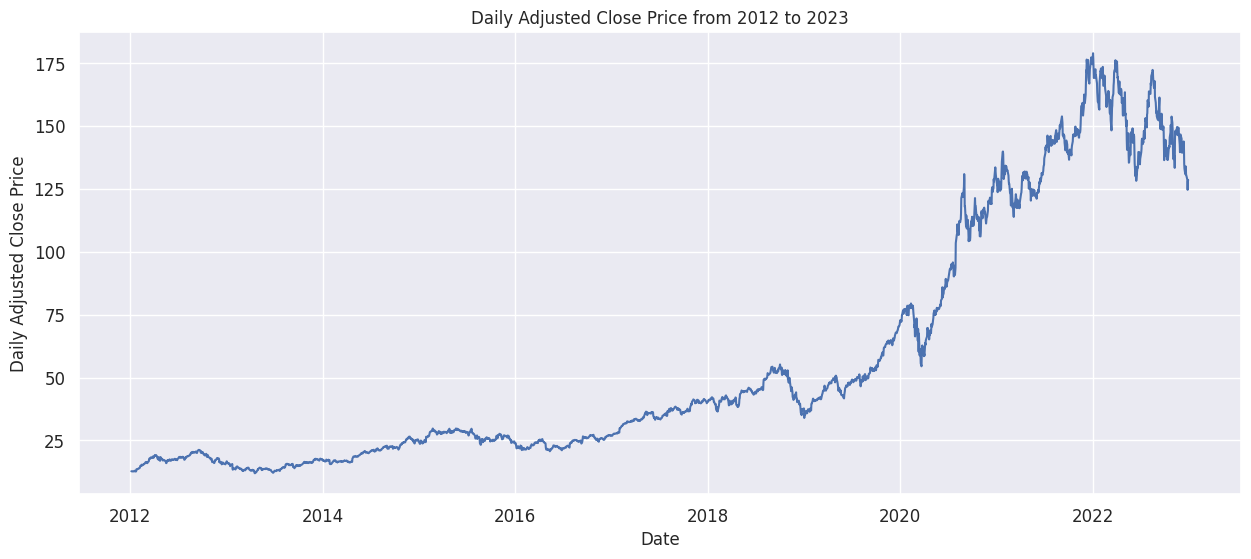

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a plot for the daily adjusted close price
fig, ax = plt.subplots(figsize=(15, 6))

# Line plot using Seaborn
sns.lineplot(x=df1_pdf.index, y='Adj Close', data=df1_pdf, ax=ax, markers=True, dashes=False)

# Set plot labels and title
ax.set_ylabel('Daily Adjusted Close Price')
ax.set_title('Daily Adjusted Close Price from 2012 to 2023')

# Display the plot
plt.show()


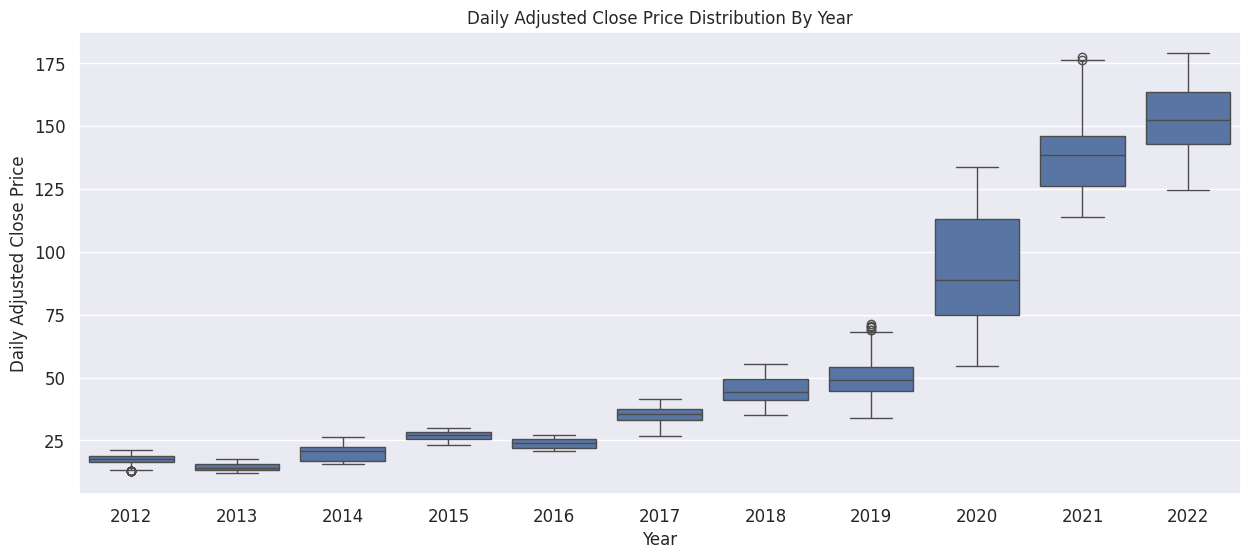

In [70]:

# Create a boxplot for the yearly distribution of daily adjusted close prices
fig, ax = plt.subplots(figsize=(15, 6))

sns.boxplot(data=df1_pdf, x='Year', y='Adj Close', ax=ax)

# Set labels and title
ax.set_ylabel('Daily Adjusted Close Price')
ax.set_title('Daily Adjusted Close Price Distribution By Year')

# Display the plot
plt.show()


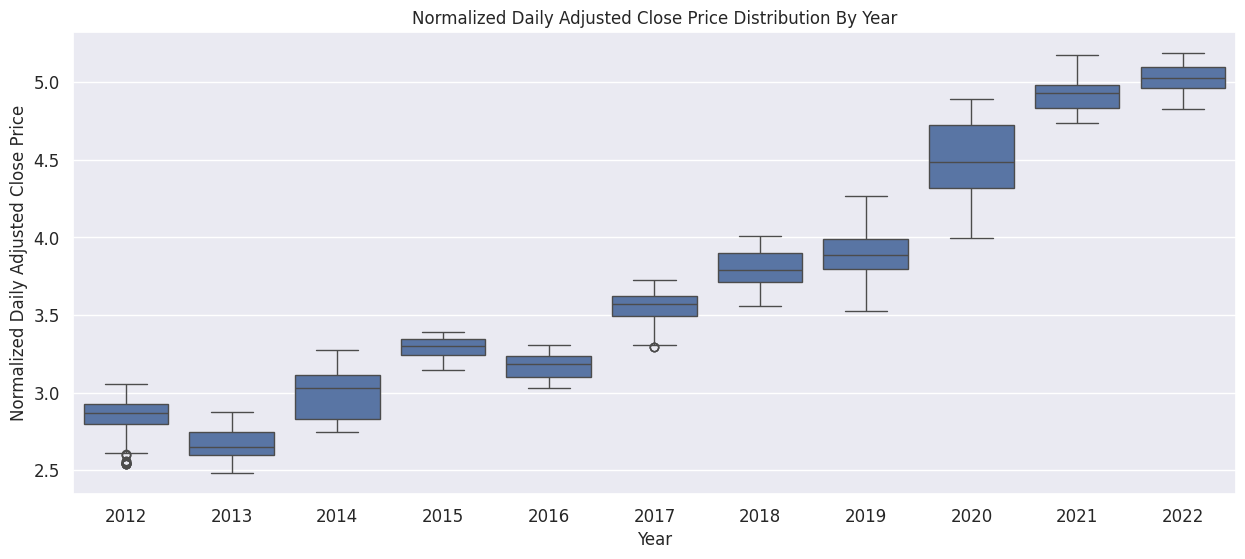

In [71]:


# Create a boxplot for the yearly distribution of normalized daily adjusted close prices
fig, ax = plt.subplots(figsize=(15, 6))

sns.boxplot(data=df1_pdf, x='Year', y='Log_Adj_Close', ax=ax)

# Set labels and title
ax.set_ylabel('Normalized Daily Adjusted Close Price')
ax.set_title('Normalized Daily Adjusted Close Price Distribution By Year')

# Display the plot
plt.show()


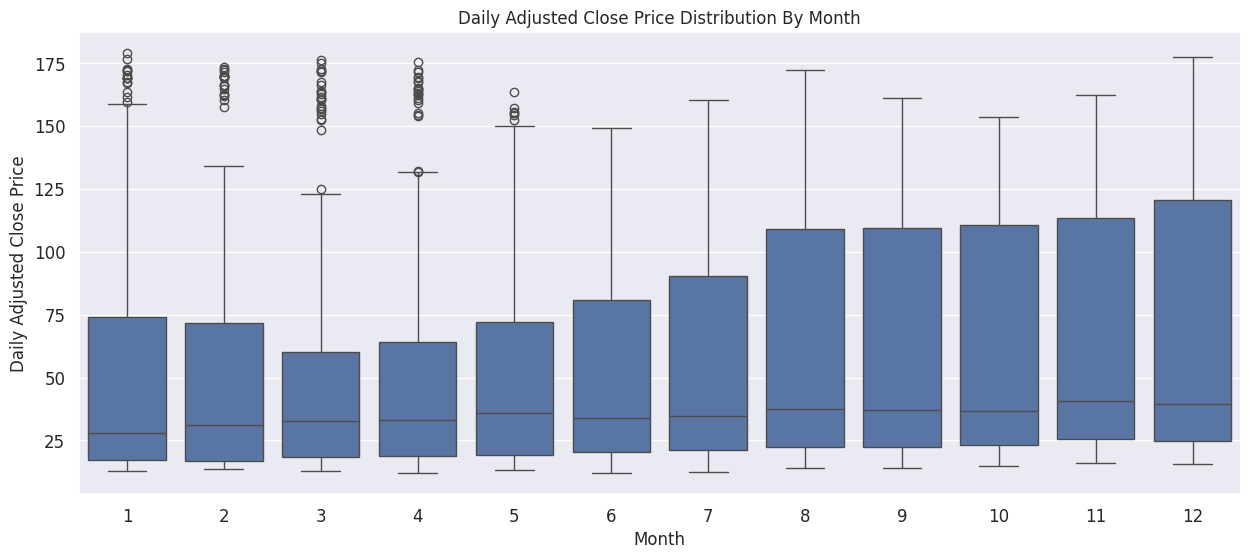

In [72]:

# Create a boxplot for the monthly distribution of daily adjusted close prices
fig, ax = plt.subplots(figsize=(15, 6))

sns.boxplot(data=df1_pdf, x='Month', y='Adj Close', ax=ax)

# Set labels and title
ax.set_ylabel('Daily Adjusted Close Price')
ax.set_title('Daily Adjusted Close Price Distribution By Month')

# Display the plot
plt.show()


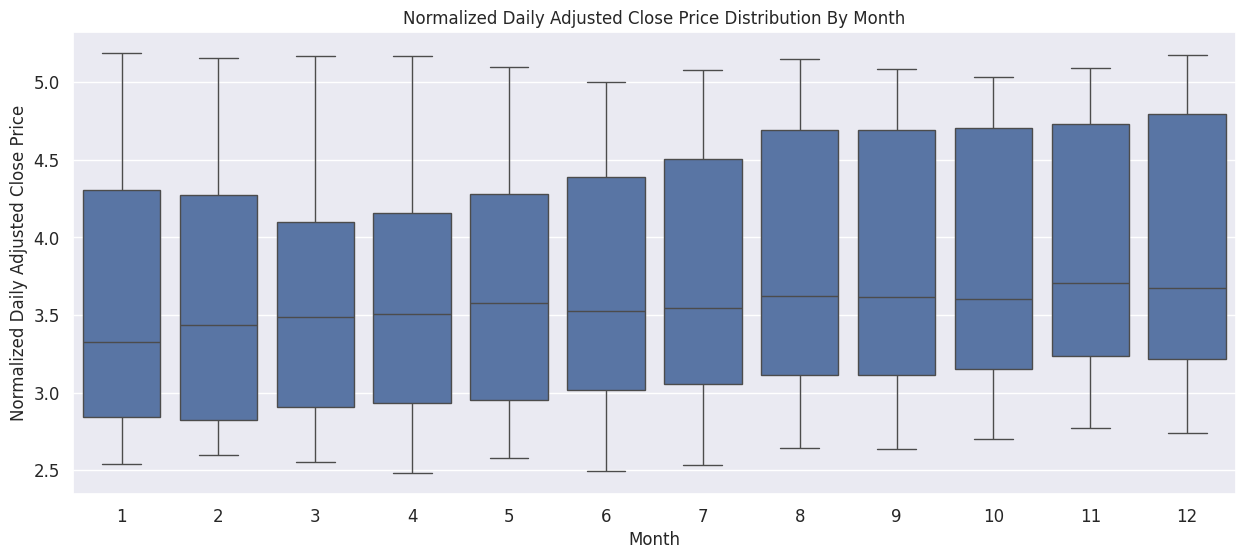

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a boxplot for the monthly distribution of normalized daily adjusted close prices
fig, ax = plt.subplots(figsize=(15, 6))

sns.boxplot(data=df1_pdf, x='Month', y='Log_Adj_Close', ax=ax)

# Set labels and title
ax.set_ylabel('Normalized Daily Adjusted Close Price')
ax.set_title('Normalized Daily Adjusted Close Price Distribution By Month')

# Display the plot
plt.show()


In [74]:
# Specify the data columns to include (excluding Year, Month, Weekday Name)
data_columns = ['Adj Close', 'Log_Adj_Close', 'Log_Diff1']

# Resample to weekly frequency, aggregating with mean
df1_pdf_weekly_mean = df1_pdf[data_columns].resample('W').mean()
print("Weekly Mean:")
print(df1_pdf_weekly_mean.head(3))

# Resample to monthly frequency, aggregating with mean
df1_pdf_monthly_mean = df1_pdf[data_columns].resample('M').mean()
print("\nMonthly Mean:")
print(df1_pdf_monthly_mean.head(3))

# Resample to quarterly frequency, aggregating with mean
df1_pdf_quarterly_mean = df1_pdf[data_columns].resample('Q').mean()
print("\nQuarterly Mean:")
print(df1_pdf_quarterly_mean.head(3))

# Resample to yearly frequency, aggregating with mean
df1_pdf_yearly_mean = df1_pdf[data_columns].resample('A').mean()
print("\nYearly Mean:")
print(df1_pdf_yearly_mean.head(3))


Weekly Mean:
            Adj Close  Log_Adj_Close  Log_Diff1
Date                                           
2012-01-08  12.725513       2.543609   0.010400
2012-01-15  12.705748       2.542051  -0.001230
2012-01-22  12.817851       2.550807   0.000292

Monthly Mean:
            Adj Close  Log_Adj_Close  Log_Diff1
Date                                           
2012-01-31  12.987898       2.563608   0.005176
2012-02-29  14.990164       2.706034   0.008627
2012-03-31  17.398394       2.854993   0.004550

Quarterly Mean:
            Adj Close  Log_Adj_Close  Log_Diff1
Date                                           
2012-03-31  15.311224       2.720540   0.006112
2012-06-30  17.506320       2.861757  -0.000417
2012-09-30  19.346807       2.960812   0.002180

Yearly Mean:
            Adj Close  Log_Adj_Close  Log_Diff1
Date                                           
2012-12-31  17.456301       2.852969   0.001013
2013-12-31  14.558543       2.673290   0.000309
2014-12-31  20.364145       3

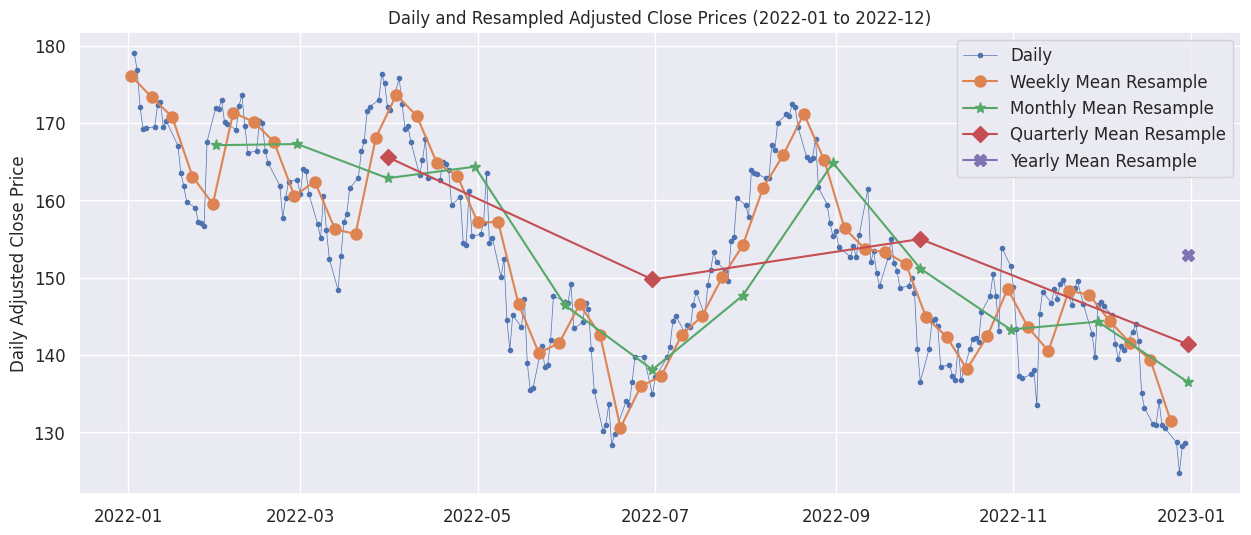

In [75]:

start, end = '2022-01', '2022-12'

# Plot daily and resampled time series together
fig, ax = plt.subplots(figsize=(15, 6))

# Daily adjusted close price
ax.plot(df1_pdf.loc[start:end, 'Adj Close'], marker='.', linestyle='-', linewidth=0.5, label='Daily')

# Weekly mean resampled adjusted close price
ax.plot(df1_pdf_weekly_mean.loc[start:end, 'Adj Close'], marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample')

# Monthly mean resampled adjusted close price
ax.plot(df1_pdf_monthly_mean.loc[start:end, 'Adj Close'], marker='*', markersize=8, linestyle='-', label='Monthly Mean Resample')

# Quarterly mean resampled adjusted close price
ax.plot(df1_pdf_quarterly_mean.loc[start:end, 'Adj Close'], marker='D', markersize=8, linestyle='-', label='Quarterly Mean Resample')

# Yearly mean resampled adjusted close price
ax.plot(df1_pdf_yearly_mean.loc[start:end, 'Adj Close'], marker='X', markersize=8, linestyle='-', label='Yearly Mean Resample')

# Set plot labels and legend
ax.set_ylabel('Daily Adjusted Close Price')
ax.set_title(f'Daily and Resampled Adjusted Close Prices ({start} to {end})')
ax.legend()

# Display the plot
plt.show()


**Key Takeaways**

**Volatility Analysis:**

Daily and weekly trends are crucial for short-term trading strategies.




**Trend Identification:**


Monthly and quarterly resampled data are valuable for long-term investment decisions.

**Smoothing Impact:**

Resampling eliminates daily noise and highlights underlying price trends.

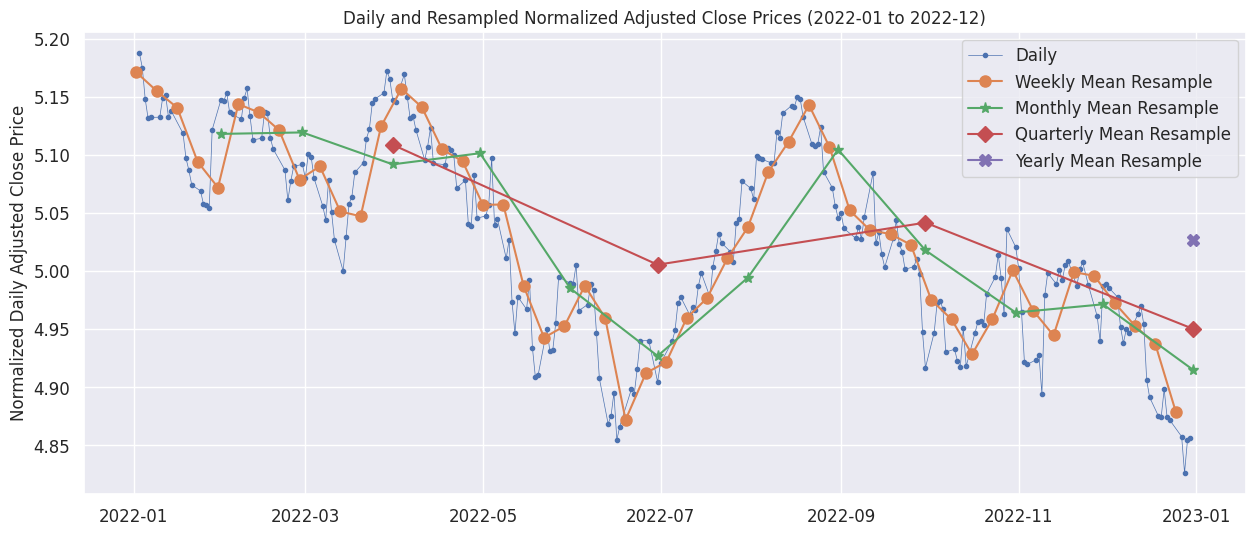

In [76]:
# Start and end of the date range
start, end = '2022-01', '2022-12'

# Plot daily and resampled time series together
fig, ax = plt.subplots(figsize=(15, 6))

# Daily normalized adjusted close price
ax.plot(df1_pdf.loc[start:end, 'Log_Adj_Close'], marker='.', linestyle='-', linewidth=0.5, label='Daily')

# Weekly mean resampled normalized adjusted close price
ax.plot(df1_pdf_weekly_mean.loc[start:end, 'Log_Adj_Close'], marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample')

# Monthly mean resampled normalized adjusted close price
ax.plot(df1_pdf_monthly_mean.loc[start:end, 'Log_Adj_Close'], marker='*', markersize=8, linestyle='-', label='Monthly Mean Resample')

# Quarterly mean resampled normalized adjusted close price
ax.plot(df1_pdf_quarterly_mean.loc[start:end, 'Log_Adj_Close'], marker='D', markersize=8, linestyle='-', label='Quarterly Mean Resample')

# Yearly mean resampled normalized adjusted close price
ax.plot(df1_pdf_yearly_mean.loc[start:end, 'Log_Adj_Close'], marker='X', markersize=8, linestyle='-', label='Yearly Mean Resample')

# Set plot labels and title
ax.set_ylabel('Normalized Daily Adjusted Close Price')
ax.set_title(f'Daily and Resampled Normalized Adjusted Close Prices ({start} to {end})')
ax.legend()

# Display the plot
plt.show()


In [77]:
# Compute the centered n-day rolling mean
df1_pdf_5d = df1_pdf[data_columns].rolling(5, center=True).mean()   # 5-day rolling mean
df1_pdf_10d = df1_pdf[data_columns].rolling(10, center=True).mean() # 10-day rolling mean
df1_pdf_21d = df1_pdf[data_columns].rolling(21, center=True).mean() # 21-day (monthly) rolling mean
df1_pdf_63d = df1_pdf[data_columns].rolling(63, center=True).mean() # 63-day (quarterly) rolling mean
df1_pdf_253d = df1_pdf[data_columns].rolling(253, center=True).mean() # 253-day (yearly) rolling mean

# Display the first 10 rows of the 5-day rolling mean
df1_pdf_5d.head(10)


,Adj Close,Log_Adj_Close,Log_Diff1
Date,,,
2012-01-06,NaN,NaN,NaN
2012-01-09,NaN,NaN,NaN
2012-01-10,12.721354,2.543281,0.001601
2012-01-11,12.705748,2.542051,-0.001230
2012-01-12,12.723644,2.543454,0.001404
2012-01-13,12.759013,2.546209,0.002755
2012-01-17,12.790345,2.548655,0.002446
2012-01-18,12.783778,2.548137,-0.000518
2012-01-19,12.829570,2.551726,0.003588


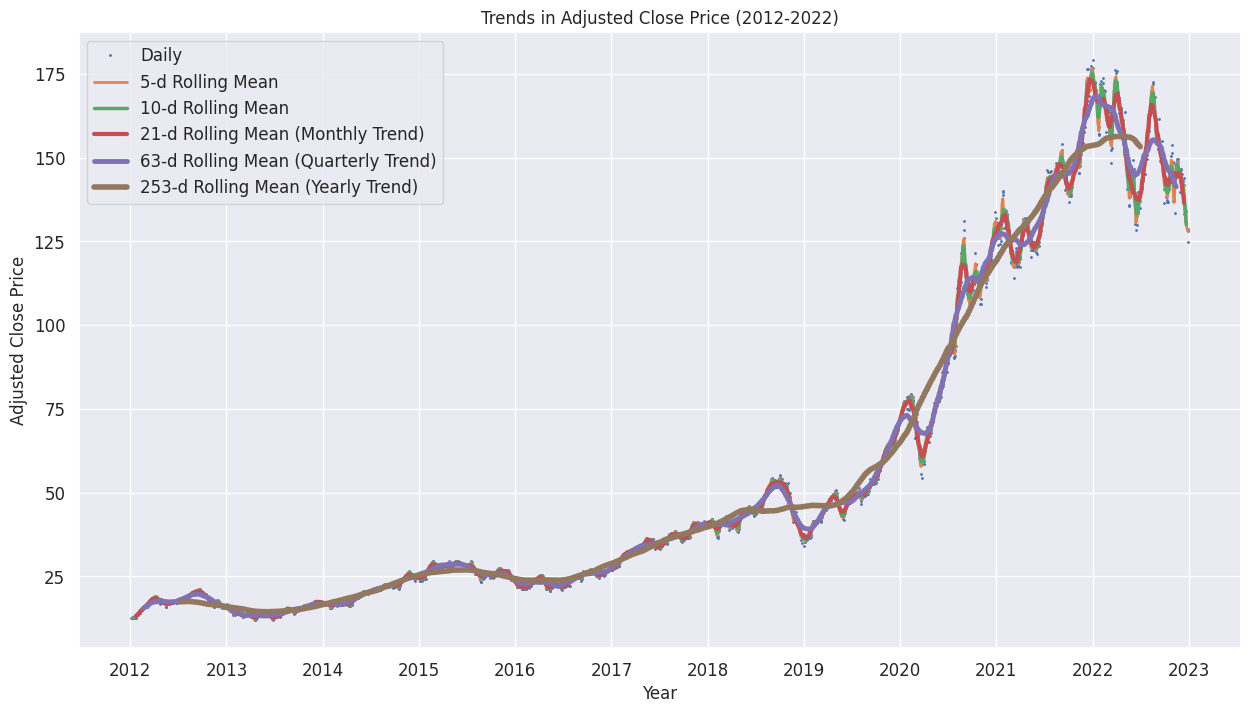

In [78]:
import matplotlib.dates as mdates

# Start and end of the date range to extract
start, end = '2012-01', '2022-12'

# Plot daily and rolling mean time series
fig, ax = plt.subplots(figsize=(15, 8))

# Plot daily prices
ax.plot(df1_pdf.loc[start:end, 'Adj Close'], marker='.', markersize=2, linestyle='None', label='Daily')

# Plot rolling means with different windows
ax.plot(df1_pdf_5d.loc[start:end, 'Adj Close'], linewidth=2, label='5-d Rolling Mean')
ax.plot(df1_pdf_10d.loc[start:end, 'Adj Close'], linewidth=2.5, label='10-d Rolling Mean')
ax.plot(df1_pdf_21d.loc[start:end, 'Adj Close'], linewidth=3, label='21-d Rolling Mean (Monthly Trend)')
ax.plot(df1_pdf_63d.loc[start:end, 'Adj Close'], linewidth=3.5, label='63-d Rolling Mean (Quarterly Trend)')
ax.plot(df1_pdf_253d.loc[start:end, 'Adj Close'], linewidth=4, label='253-d Rolling Mean (Yearly Trend)')

# Set x-ticks to yearly intervals and format them
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add legend, labels, and title
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Adjusted Close Price')
ax.set_title('Trends in Adjusted Close Price (2012-2022)')

# Display the plot
plt.show()


In [79]:
from pyspark.ml.feature import PCA, VectorAssembler
import pandas as pd

# Define the columns for PCA
pca_columns = ['Lag_VIX1', 'Lag_BY1', 'weekDay_Nu', 'lag1', 'daily_return',
               'daily_mean', 'daily_std', 'dailyreturn_mean', 'dailyreturn_std']

# Assemble the features into a single vector
pca_assembler = VectorAssembler(inputCols=pca_columns, outputCol="features")
pca_output = pca_assembler.transform(df1)

# Perform PCA
pca = PCA(k=8, inputCol="features", outputCol="pcaFeatures")
pca_model = pca.fit(pca_output)

# Transform the data to include PCA features
df_PCA = pca_model.transform(pca_output).select('Date', 'Log_Diff1', 'pcaFeatures')
df_PCA.show(truncate=False)

# Extract the principal components
m = pca_model.pc.toArray().reshape(9, 8).transpose()
m_df = pd.DataFrame(m)
m_df.columns = pca_columns

# Display the feature contributions
print("The Corresponding Daily Features and Their PCA Contributions: ")
print(m_df.idxmax(axis=1).values)

# Display the explained variance
print("Explained Variance for Each Principal Component: ")
print(pca_model.explainedVariance)


+-------------------+----------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Date               |Log_Diff1             |pcaFeatures                                                                                                                                                       |
+-------------------+----------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|2012-01-06 00:00:00|0.010399696611380627  |[0.6828067734404605,0.6207660727767402,-0.13494548793649083,6.007671180353507,3.5887342934300603,-0.4784141079808019,0.0353052197929066,-0.049714205065874116]    |
|2012-01-09 00:00:00|-0.0015877052022230664|[-0.525629903543267,1.3239074826056823,0.5254915994899199,2.0036342103643063,3.561029466112192,-0.4887056364754158,0.0297377

In [80]:
m_df.head(9)

,Lag_VIX1,Lag_BY1,weekDay_Nu,lag1,daily_return,daily_mean,daily_std,dailyreturn_mean,dailyreturn_std
0,-0.000072,0.000098,-0.000945,0.000006,0.629778,0.000009,0.000001,0.463216,0.623546
1,-0.000192,0.000166,0.000593,0.000021,-0.728145,0.000018,0.000037,0.072479,0.681580
2,-0.000479,0.000267,0.003579,0.000002,0.270527,0.000026,0.000088,-0.883270,0.382932
3,0.002598,-0.000548,0.999989,-0.000086,0.000059,-0.000561,-0.000210,0.003554,-0.001185
4,0.906326,0.422264,-0.002120,-0.005094,0.000026,-0.002140,0.015202,-0.000272,0.000211
5,0.422210,-0.906467,-0.001593,-0.004734,0.000026,-0.002401,0.004996,-0.000326,0.000404
6,0.007552,-0.002448,0.000332,0.862589,0.000010,0.505362,-0.022045,0.000002,-0.000026
7,-0.015724,-0.001945,0.000256,0.020720,0.000002,0.008464,0.999624,0.000081,-0.000066


In [81]:
import numpy as np

# Define the sMAPE function for evaluating model performance
def smape(actual, predicted):
    """
    Compute symmetric Mean Absolute Percentage Error (sMAPE).

    Parameters:
    - actual: Array-like, ground truth values
    - predicted: Array-like, predicted values

    Returns:
    - sMAPE: Symmetric Mean Absolute Percentage Error (float)
    """
    actual, predicted = np.array(actual), np.array(predicted)
    return 100 / len(actual) * np.sum(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted) + 1e-8))


In [82]:
from pyspark.ml.feature import VectorAssembler

# Create the vector assembler for df1 (daily horizon)
assembler1 = VectorAssembler(
    inputCols=['Lag_VIX1', 'Lag_BY1', 'weekDay_Nu', 'lag1',
               'daily_return', 'daily_mean', 'daily_std',
               'dailyreturn_mean', 'dailyreturn_std'],
    outputCol="features"
)

# Transform df1 with the vector assembler
output1 = assembler1.transform(df1)

# Select only the required columns from df1
df1 = output1.select('Date', 'Adj Close', 'Log_Adj_Close', 'Lag_1', 'Log_Diff1', 'features')


In [83]:

# Define a window to preserve data sequence based on the Date column
w = Window.partitionBy().orderBy("Date")

# Add a rank column based on percent rank to split the data
df1 = df1.withColumn("rank", f.percent_rank().over(w))

# Split into training and testing datasets
train_df1 = df1.where("rank <= 0.8").drop('rank')  # 80% for training
test_df1 = df1.where("rank > 0.8").drop('rank')   # 20% for testing

# Verify the splits
print(f"Training Dataset: {train_df1.count()} rows")
print(f"Testing Dataset: {test_df1.count()} rows")


Training Dataset: 2202 rows
Testing Dataset: 551 rows


In [84]:

# Initialize Linear Regression model
lr = LinearRegression(maxIter=100, featuresCol="features", labelCol="Log_Diff1")

# Create a parameter grid for hyperparameter tuning
ParamGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01, 0.001]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

# Create TrainValidationSplit for model generalization
Tvs = TrainValidationSplit(
    estimator=lr,
    estimatorParamMaps=ParamGrid,
    evaluator=RegressionEvaluator(labelCol="Log_Diff1", predictionCol="prediction", metricName="rmse"),
    trainRatio=0.8
)


In [85]:


# Initialize Gradient Boosted Tree Regressor
gbtr = GBTRegressor(featuresCol="features", labelCol="Log_Diff1", maxIter=30)

# Create a parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder()\
    .addGrid(gbtr.maxBins, [32, 64])\
    .addGrid(gbtr.maxDepth, [5, 10])\
    .build()

# Create TrainValidationSplit for model generalization
Tvs_gb = TrainValidationSplit(
    estimator=gbtr,
    estimatorParamMaps=paramGrid,
    evaluator=RegressionEvaluator(labelCol="Log_Diff1", predictionCol="prediction", metricName="rmse"),
    trainRatio=0.8
)


In [86]:

# Initialize Random Forest Regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="Log_Diff1")

# Create a parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [20, 25, 30])\
    .addGrid(rf.maxDepth, [5, 10, 15])\
    .addGrid(rf.maxBins, [16, 32, 64])\
    .build()

# Create TrainValidationSplit for model generalization
Tvs_rf = TrainValidationSplit(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=RegressionEvaluator(labelCol="Log_Diff1", predictionCol="prediction", metricName="rmse"),
    trainRatio=0.8
)


In [87]:

# Initialize Decision Tree Regressor
dtr = DecisionTreeRegressor(featuresCol="features", labelCol="Log_Diff1")

# Create a parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder()\
    .addGrid(dtr.maxDepth, [5, 10, 15])\
    .addGrid(dtr.maxBins, [16, 32, 64])\
    .addGrid(dtr.seed, [42])\
    .build()

# Create TrainValidationSplit for model generalization
Tvs_dt = TrainValidationSplit(
    estimator=dtr,
    estimatorParamMaps=paramGrid,
    evaluator=RegressionEvaluator(labelCol="Log_Diff1", predictionCol="prediction", metricName="rmse"),
    trainRatio=0.8
)


In [88]:

# Rename Log_Diff1 to label for model compatibility
train_df_min = train_df1.withColumnRenamed("Log_Diff1", "label").select("features", "label")
test_df_min = test_df1.withColumnRenamed("Log_Diff1", "label").select("features", "label")

# Reinitialize Linear Regression
lr = LinearRegression(maxIter=100, featuresCol="features", labelCol="label")

# Rebuild the parameter grid
ParamGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01, 0.001])\
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

# Fresh TrainValidationSplit instance
Tvs = TrainValidationSplit(
    estimator=lr,
    estimatorParamMaps=ParamGrid,
    evaluator=RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse"),
    trainRatio=0.8
)

# Fit the model
model1 = Tvs.fit(train_df_min)

# Predictions on training and test datasets
lr_preds_train = model1.transform(train_df_min)
lr_preds_test = model1.transform(test_df_min)

# Evaluate RMSE
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
train_rmse = lr_evaluator.evaluate(lr_preds_train)
test_rmse = lr_evaluator.evaluate(lr_preds_test)

print("Tuned Linear Regression Model on 1-Day RMSE on Training Data = %g" % train_rmse)
print("Tuned Linear Regression Model on 1-Day RMSE on Test Data = %g" % test_rmse)


Tuned Linear Regression Model on 1-Day RMSE on Training Data = 0.00252778
Tuned Linear Regression Model on 1-Day RMSE on Test Data = 0.00270084


In [89]:
# Rename Log_Diff1 to label for training and testing datasets
train_df_1 = train_df1.withColumnRenamed("Log_Diff1", "label")
test_df_1 = test_df1.withColumnRenamed("Log_Diff1", "label")

# Instantiate the Linear Regression model with tuned parameters
lr = LinearRegression(featuresCol='features', labelCol='label', regParam=0.001, elasticNetParam=1.0, fitIntercept=True, maxIter=100)
lr_model_1 = lr.fit(train_df_1)

# Generate predictions on training and testing datasets
training_pred_data1 = lr_model_1.transform(train_df_1)
testing_pred_data1 = lr_model_1.transform(test_df_1)

# Converting predictions back to the original scale for training data
training_pred_data1 = (
    training_pred_data1.withColumnRenamed("label", "Log_Diff1")
    .withColumnRenamed("prediction", "Log_Diff_Prediction")
    .withColumn("predicted_adj_close", f.exp(f.col("Lag_1")) * f.exp(f.col("Log_Diff_Prediction")))
    .withColumnRenamed("Adj Close", "label")
    .withColumnRenamed("predicted_adj_close", "prediction")
)

# Converting predictions back to the original scale for testing data
testing_pred_data1 = (
    testing_pred_data1.withColumnRenamed("label", "Log_Diff1")
    .withColumnRenamed("prediction", "Log_Diff_Prediction")
    .withColumn("predicted_adj_close", f.exp(f.col("Lag_1")) * f.exp(f.col("Log_Diff_Prediction")))
    .withColumnRenamed("Adj Close", "label")
    .withColumnRenamed("predicted_adj_close", "prediction")
)

# Collect actual and predicted values for evaluation
A_tr1 = np.array(training_pred_data1.select('label').rdd.map(lambda row: row[0]).collect())
P_tr1 = np.array(training_pred_data1.select('prediction').rdd.map(lambda row: row[0]).collect())
A_te1 = np.array(testing_pred_data1.select('label').rdd.map(lambda row: row[0]).collect())
P_te1 = np.array(testing_pred_data1.select('prediction').rdd.map(lambda row: row[0]).collect())

# Evaluate the model
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
train_rmse = lr_evaluator.evaluate(training_pred_data1)
test_rmse = lr_evaluator.evaluate(testing_pred_data1)

# Print evaluation metrics
print("Linear Regression Model on 1-Day RMSE on Training Data = %g" % train_rmse)
print("Linear Regression Model on 1-Day RMSE on Testing Data = %g" % test_rmse)
print("Linear Regression Model on 1-Day sMAPE on Training Data = %g" % smape(A_tr1, P_tr1))
print("Linear Regression Model on 1-Day sMAPE on Testing Data = %g" % smape(A_te1, P_te1))


Linear Regression Model on 1-Day RMSE on Training Data = 0.129551
Linear Regression Model on 1-Day RMSE on Testing Data = 0.384531
Linear Regression Model on 1-Day sMAPE on Training Data = 0.172314
Linear Regression Model on 1-Day sMAPE on Testing Data = 0.203599


In [90]:
# Define the RC parameters for consistent Seaborn plots
rc = {
    'font.size': 14,                   # Adjusted font size for better readability
    'axes.labelsize': 14,              # Font size for axis labels
    'legend.fontsize': 14.0,           # Font size for legend
    'axes.titlesize': 16,              # Font size for titles
    'xtick.labelsize': 12,             # Font size for x-axis tick labels
    'ytick.labelsize': 12,             # Font size for y-axis tick labels
    'figure.figsize': (15, 8)          # Adjusted figure size for clarity
}
sns.set(rc=rc)


In [91]:
# Extract parameter grids and corresponding validation metrics
params = [{p.name: v for p, v in m.items()} for m in model1.getEstimatorParamMaps()]
lr_rdf = pd.DataFrame.from_dict([
    {model1.getEvaluator().getMetricName(): metric, **ps}
    for ps, metric in zip(params, model1.validationMetrics)
])

# Display the first 50 rows for detailed analysis
lr_rdf.head(50)


,rmse,regParam,fitIntercept,elasticNetParam
0,0.015002,0.100,False,0.0
1,0.016187,0.100,False,0.5
2,0.016187,0.100,False,1.0
3,0.015015,0.100,True,0.0
4,0.016134,0.100,True,0.5
5,0.016134,0.100,True,1.0
6,0.009875,0.010,False,0.0
7,0.013322,0.010,False,0.5
8,0.014708,0.010,False,1.0
9,0.009879,0.010,True,0.0


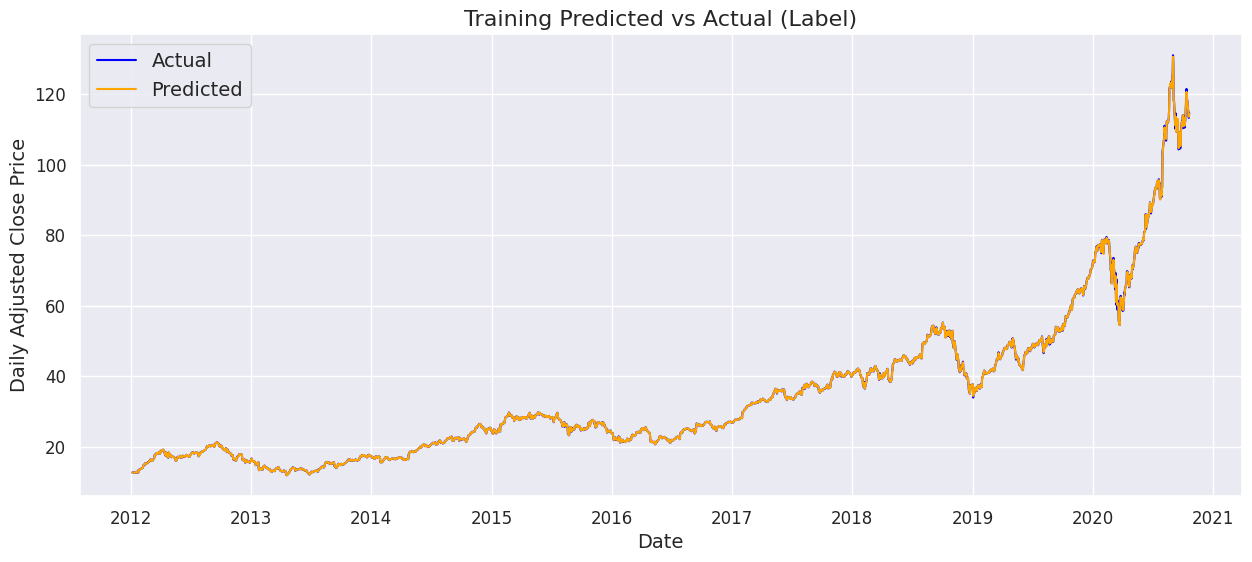

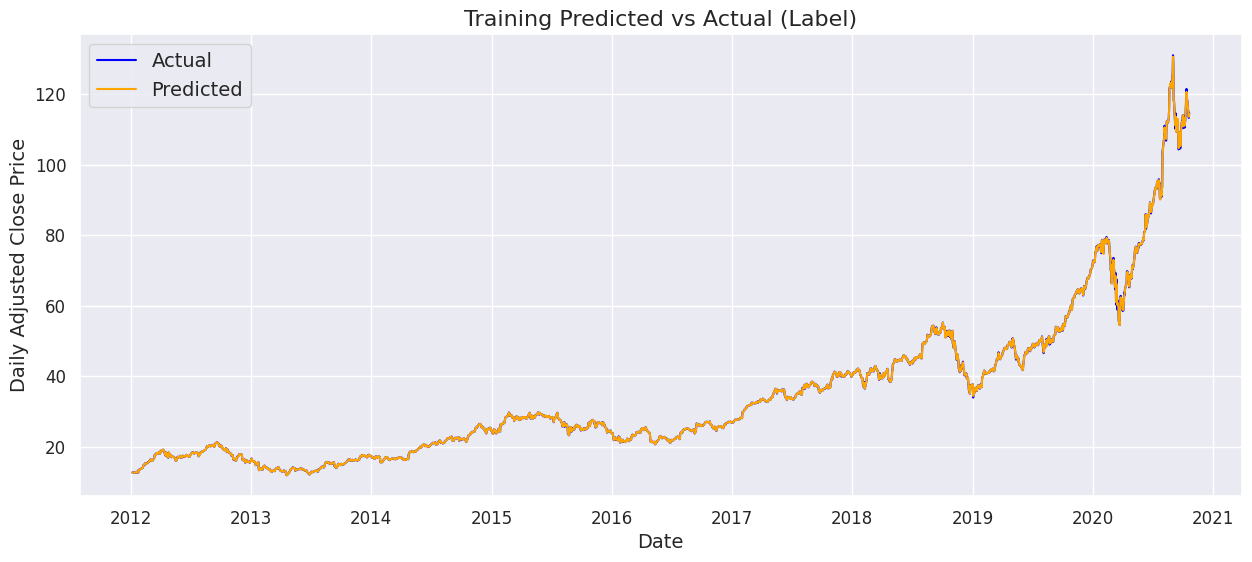

In [92]:
# Convert training predictions to pandas DataFrame
training_pred_data1_pdf = training_pred_data1.select('Date', 'prediction', 'label').toPandas()

# Set 'Date' as the index
training_pred_data1_pdf = training_pred_data1_pdf.set_index('Date')

# Plot the predicted vs actual values for training data
fig, ax = plt.subplots(figsize=(15, 6))  # Adjust figure size for clarity

# Plot actual values (label)
sns.lineplot(data=training_pred_data1_pdf, x=training_pred_data1_pdf.index, y='label', ax=ax, label='Actual', color='blue')

# Plot predicted values
sns.lineplot(data=training_pred_data1_pdf, x=training_pred_data1_pdf.index, y='prediction', ax=ax, label='Predicted', color='orange')

# Set x-axis to show yearly intervals
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Label the axes and add a legend
ax.set_ylabel('Daily Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Training Predicted vs Actual (Label)')

# Display the plot
display(fig)


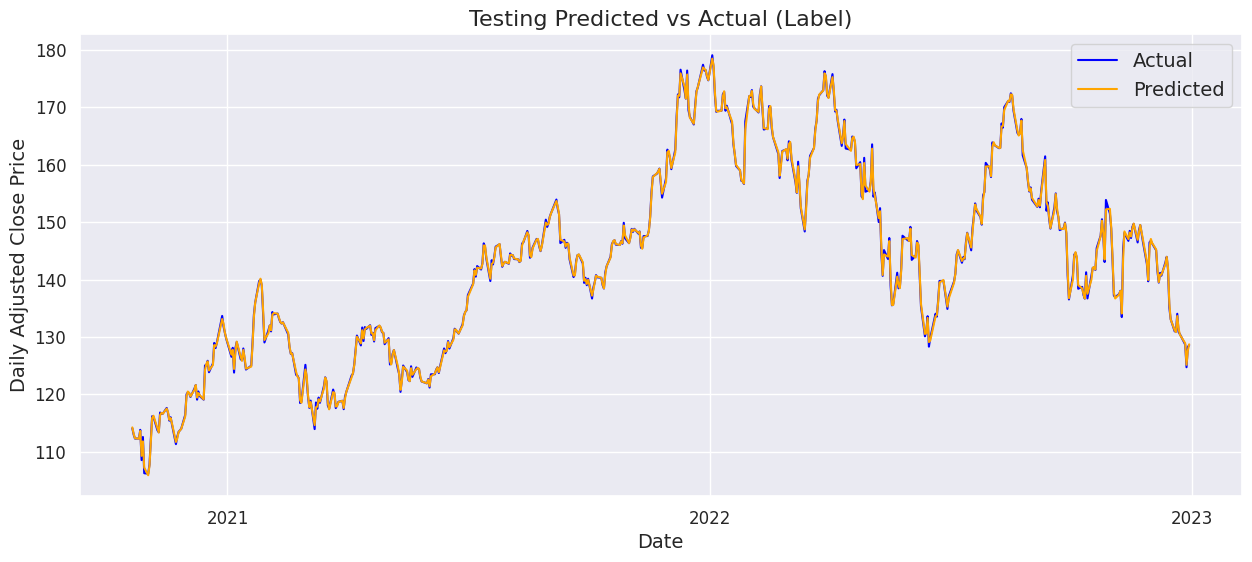

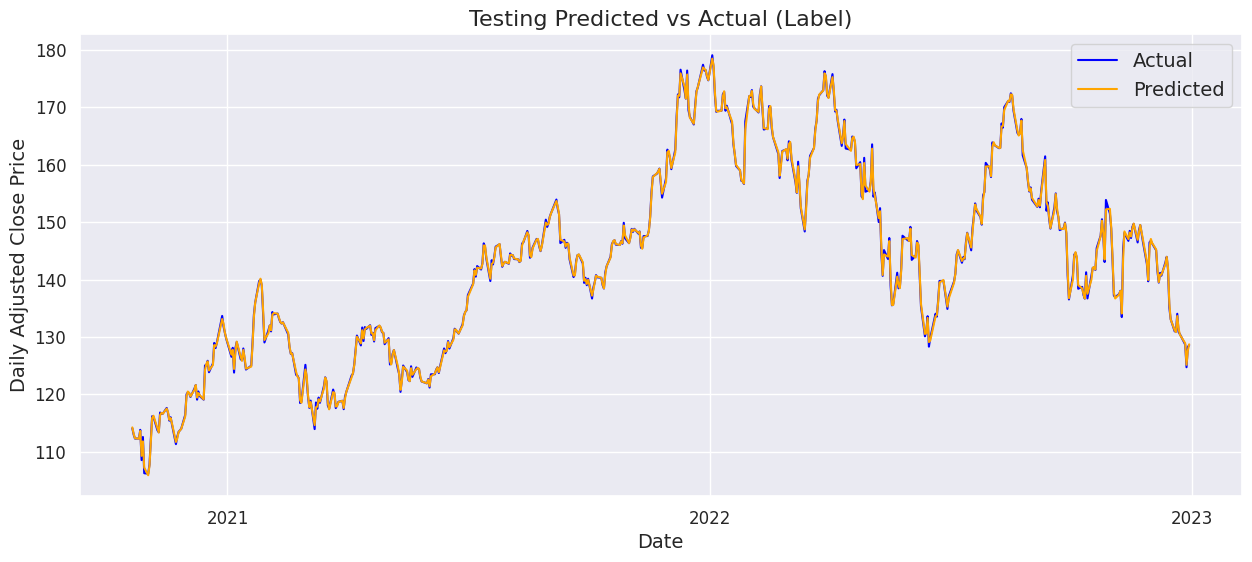

In [93]:
# Convert testing predictions to pandas DataFrame
testing_pred_data1_pdf = testing_pred_data1.select('Date', 'prediction', 'label').toPandas()

# Set 'Date' as the index
testing_pred_data1_pdf = testing_pred_data1_pdf.set_index('Date')

# Plot the predicted vs actual values for testing data
fig, ax = plt.subplots(figsize=(15, 6))  # Adjust figure size for clarity

# Plot actual values (label)
sns.lineplot(data=testing_pred_data1_pdf, x=testing_pred_data1_pdf.index, y='label', ax=ax, label='Actual', color='blue')

# Plot predicted values
sns.lineplot(data=testing_pred_data1_pdf, x=testing_pred_data1_pdf.index, y='prediction', ax=ax, label='Predicted', color='orange')

# Set x-axis to show yearly intervals
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Label the axes and add a legend
ax.set_ylabel('Daily Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Testing Predicted vs Actual (Label)')

# Display the plot
display(fig)


Random Forest


In [94]:
from pyspark.sql.functions import col

# Define the training and testing date ranges
training_end_date = "2021-12-31"
testing_start_date = "2022-01-01"

# Filter for training data (2012–2021)
train_df_rf_1 = df.filter(col("Date") <= training_end_date)

# Filter for testing data (2022–2023)
test_df_rf_1 = df.filter(col("Date") >= testing_start_date)


In [95]:
from pyspark.sql.functions import col, exp
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator

# Step 1: Prepare the training and testing datasets
train_df_rf_1 = train_df1.withColumnRenamed("Log_Diff1", "label")
test_df_rf_1 = test_df1.withColumnRenamed("Log_Diff1", "label")

# Preserve all necessary columns for post-prediction transformations
train_df_rf_1 = train_df_rf_1.select("features", "label", "Lag_1", "Adj Close", "Date")
test_df_rf_1 = test_df_rf_1.select("features", "label", "Lag_1", "Adj Close", "Date")

# Step 2: Initialize Random Forest Regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="label")

# Step 3: Define the parameter grid
paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [20, 25, 30])\
    .addGrid(rf.maxDepth, [5, 10, 15])\
    .addGrid(rf.maxBins, [16, 32, 64])\
    .build()

# Step 4: Set up TrainValidationSplit
Tvs_rf = TrainValidationSplit(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse"),
    trainRatio=0.8
)

# Step 5: Train the model
model_rf = Tvs_rf.fit(train_df_rf_1)

# Step 6: Generate predictions
rf_preds_train1 = model_rf.transform(train_df_rf_1)
rf_preds_test1 = model_rf.transform(test_df_rf_1)

# Step 7: Evaluate RMSE
rf_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
train_rmse = rf_evaluator.evaluate(rf_preds_train1)
test_rmse = rf_evaluator.evaluate(rf_preds_test1)

# Step 8: Converting predictions back to the original scale for training data
rf_preds_train1 = (
    rf_preds_train1.withColumnRenamed("label", "Log_Diff1")
    .withColumnRenamed("prediction", "Log_Diff_Prediction")
    .withColumn("predicted_adj_close", exp(col("Lag_1")) * exp(col("Log_Diff_Prediction")))
    .withColumnRenamed("Adj Close", "label")
    .withColumnRenamed("predicted_adj_close", "prediction")
)

# Step 9: Converting predictions back to the original scale for testing data
rf_preds_test1 = (
    rf_preds_test1.withColumnRenamed("label", "Log_Diff1")
    .withColumnRenamed("prediction", "Log_Diff_Prediction")
    .withColumn("predicted_adj_close", exp(col("Lag_1")) * exp(col("Log_Diff_Prediction")))
    .withColumnRenamed("Adj Close", "label")
    .withColumnRenamed("predicted_adj_close", "prediction")
)

# Step 10: Extract actual and predicted values for evaluation
A_trt_rf1 = np.array(rf_preds_train1.select('label').rdd.map(lambda row: row[0]).collect())
P_trt_rf1 = np.array(rf_preds_train1.select('prediction').rdd.map(lambda row: row[0]).collect())
A_tet_rf1 = np.array(rf_preds_test1.select('label').rdd.map(lambda row: row[0]).collect())
P_tet_rf1 = np.array(rf_preds_test1.select('prediction').rdd.map(lambda row: row[0]).collect())

# Step 11: Print evaluation metrics
print("Tuned Random Forest Model on 1-Day RMSE on Training Data = %g" % train_rmse)
print("Tuned Random Forest Model on 1-Day RMSE on Testing Data = %g" % test_rmse)
print("Tuned Random Forest Model on 1-Day sMAPE Value on Training = %g" % smape(A_trt_rf1, P_trt_rf1))
print("Tuned Random Forest Model on 1-Day sMAPE Value on Testing Data = %g" % smape(A_tet_rf1, P_tet_rf1))


Tuned Random Forest Model on 1-Day RMSE on Training Data = 0.00230604
Tuned Random Forest Model on 1-Day RMSE on Testing Data = 0.00359247
Tuned Random Forest Model on 1-Day sMAPE Value on Training = 0.0848883
Tuned Random Forest Model on 1-Day sMAPE Value on Testing Data = 0.194421


In [96]:
params = [{p.name: v for p, v in m.items()} for m in model1.getEstimatorParamMaps()]
lr_rdf = pd.DataFrame.from_dict([{model1.getEvaluator().getMetricName(): metric, **ps} for ps, metric in zip(params, model1.validationMetrics)])
lr_rdf.head(50)

,rmse,regParam,fitIntercept,elasticNetParam
0,0.015002,0.100,False,0.0
1,0.016187,0.100,False,0.5
2,0.016187,0.100,False,1.0
3,0.015015,0.100,True,0.0
4,0.016134,0.100,True,0.5
5,0.016134,0.100,True,1.0
6,0.009875,0.010,False,0.0
7,0.013322,0.010,False,0.5
8,0.014708,0.010,False,1.0
9,0.009879,0.010,True,0.0


In [97]:
# Prepare training and testing datasets with necessary columns
train_df_rf_min = train_df_rf_1.select("features", "label", "Lag_1", "Adj Close")
test_df_rf_min = test_df_rf_1.select("features", "label", "Lag_1", "Adj Close")

# Building a model to forecast the one-day stock price using Random Forest
rf = RandomForestRegressor(featuresCol='features', labelCol='label', maxDepth=15, maxBins=32, numTrees=30)
rf_model1 = rf.fit(train_df_rf_min)  # Use the training DataFrame with necessary columns

# Make predictions on training and testing datasets
train_rf_preds1 = rf_model1.transform(train_df_rf_min)
test_rf_preds1 = rf_model1.transform(test_df_rf_min)

# Evaluate RMSE
rf_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
train_rmse = rf_evaluator.evaluate(train_rf_preds1)
test_rmse = rf_evaluator.evaluate(test_rf_preds1)

# Convert predictions back to the original scale for training data
train_rf_preds1 = (
    train_rf_preds1.withColumnRenamed("label", "Log_Diff1")
    .withColumnRenamed("prediction", "Log_Diff_Prediction")
    .withColumn("predicted_adj_close", f.exp(f.col("Lag_1")) * f.exp(f.col("Log_Diff_Prediction")))
    .withColumnRenamed("Adj Close", "label")
    .withColumnRenamed("predicted_adj_close", "prediction")
)

# Convert predictions back to the original scale for testing data
test_rf_preds1 = (
    test_rf_preds1.withColumnRenamed("label", "Log_Diff1")
    .withColumnRenamed("prediction", "Log_Diff_Prediction")
    .withColumn("predicted_adj_close", f.exp(f.col("Lag_1")) * f.exp(f.col("Log_Diff_Prediction")))
    .withColumnRenamed("Adj Close", "label")
    .withColumnRenamed("predicted_adj_close", "prediction")
)

# Extract actual and predicted values for evaluation
A_tr_rf1 = np.array(train_rf_preds1.select('label').rdd.map(lambda row: row[0]).collect())
P_tr_rf1 = np.array(train_rf_preds1.select('prediction').rdd.map(lambda row: row[0]).collect())
A_te_rf1 = np.array(test_rf_preds1.select('label').rdd.map(lambda row: row[0]).collect())
P_te_rf1 = np.array(test_rf_preds1.select('prediction').rdd.map(lambda row: row[0]).collect())

# Print evaluation metrics
print("Random Forest Model on 1-Day RMSE on Training Data = %g" % train_rmse)
print("Random Forest Model on 1-Day RMSE on Testing Data = %g" % test_rmse)
print("Random Forest Model on 1-Day sMAPE on Training = %g" % smape(A_tr_rf1, P_tr_rf1))
print("Random Forest Model on 1-Day sMAPE on Testing Data = %g" % smape(A_te_rf1, P_te_rf1))


Random Forest Model on 1-Day RMSE on Training Data = 0.00235516
Random Forest Model on 1-Day RMSE on Testing Data = 0.00401727
Random Forest Model on 1-Day sMAPE on Training = 0.0947845
Random Forest Model on 1-Day sMAPE on Testing Data = 0.218201


In [98]:
from pyspark.sql.functions import monotonically_increasing_id

# Add row IDs to align the DataFrames
df = df.withColumn("row_id", monotonically_increasing_id())
train_rf_preds1 = train_rf_preds1.withColumn("row_id", monotonically_increasing_id())

# Join on row_id
train_rf_preds1 = train_rf_preds1.join(df.select("row_id", "Date"), on="row_id", how="inner").drop("row_id")


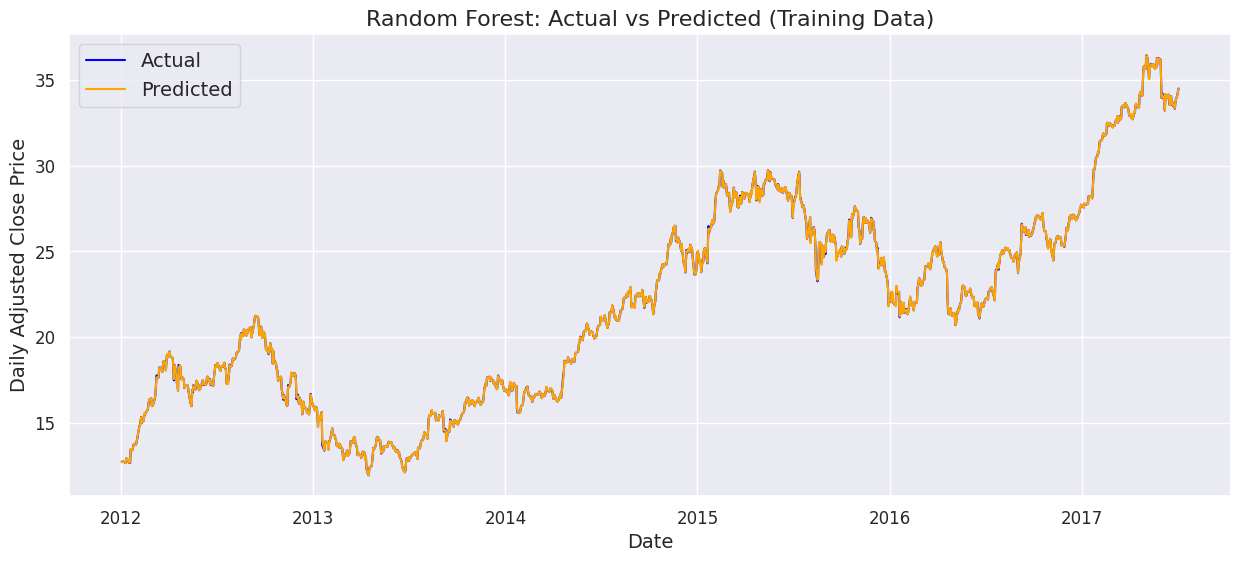

In [99]:
# Convert predictions to pandas DataFrame for visualization
train_rf_preds1_pdf = train_rf_preds1.select('Date', 'prediction', 'label').toPandas()

# Set 'Date' as the index
train_rf_preds1_pdf = train_rf_preds1_pdf.set_index('Date')

# Plot the actual vs. predicted values
fig, ax = plt.subplots(figsize=(15, 6))  # Adjust figure size for clarity

# Plot actual values (label)
sns.lineplot(data=train_rf_preds1_pdf, x=train_rf_preds1_pdf.index, y='label', ax=ax, label='Actual', color='blue')

# Plot predicted values
sns.lineplot(data=train_rf_preds1_pdf, x=train_rf_preds1_pdf.index, y='prediction', ax=ax, label='Predicted', color='orange')

# Set x-axis to show yearly intervals
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Label the axes and add a legend
ax.set_ylabel('Daily Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Random Forest: Actual vs Predicted (Training Data)')

# Display the plot
plt.show()


In [100]:
from pyspark.sql.functions import monotonically_increasing_id

# Add row IDs to align the DataFrames
df = df.withColumn("row_id", monotonically_increasing_id())
test_rf_preds1 = test_rf_preds1.withColumn("row_id", monotonically_increasing_id())

# Join the Date column from df to test_rf_preds1
test_rf_preds1 = test_rf_preds1.join(df.select("row_id", "Date"), on="row_id", how="inner").drop("row_id")


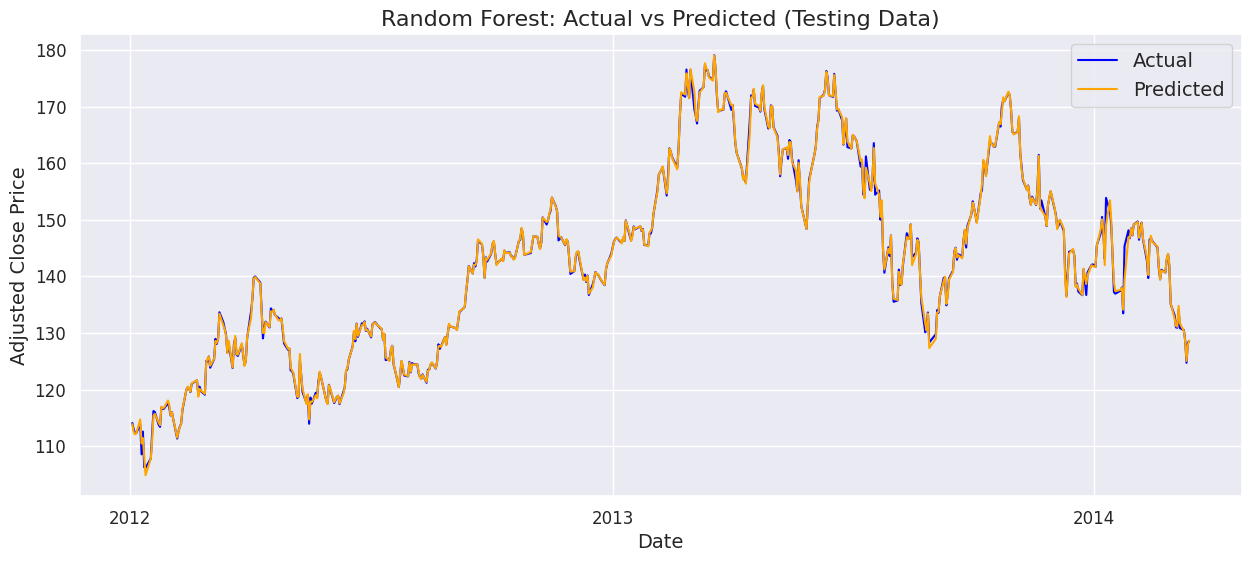

In [101]:
# Convert predictions to pandas DataFrame
test_rf_preds1_pdf = test_rf_preds1.select('Date', 'prediction', 'label').toPandas()

# Set 'Date' as the index
test_rf_preds1_pdf['Date'] = pd.to_datetime(test_rf_preds1_pdf['Date'])
test_rf_preds1_pdf = test_rf_preds1_pdf.set_index('Date')

# Plot actual vs predicted values

fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(data=test_rf_preds1_pdf, x=test_rf_preds1_pdf.index, y='label', label='Actual', color='blue', ax=ax)
sns.lineplot(data=test_rf_preds1_pdf, x=test_rf_preds1_pdf.index, y='prediction', label='Predicted', color='orange', ax=ax)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_ylabel('Adjusted Close Price')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Random Forest: Actual vs Predicted (Testing Data)')

plt.show()


Decision tree

In [102]:
# Step 1: Prepare Training and Testing Data
train_df_dt_1 = train_df1.withColumnRenamed("Log_Diff1", "label")
test_df_dt_1 = test_df1.withColumnRenamed("Log_Diff1", "label")

# Step 2: Train the Decision Tree Model
decision_tree = DecisionTreeRegressor(featuresCol="features", labelCol="label")
model1 = decision_tree.fit(train_df_dt_1)

# Step 3: Generate Predictions
dt_preds_train1 = model1.transform(train_df_dt_1)
dt_preds_test1 = model1.transform(test_df_dt_1)

# Step 4: Convert Predictions Back to Original Scale for Training Data
dt_preds_train1 = (
    dt_preds_train1
    .withColumnRenamed("label", "Log_Diff1")
    .withColumnRenamed("prediction", "Log_Diff_Prediction")
    .withColumn("predicted_adj_close", f.exp(f.col("Lag_1")) * f.exp(f.col("Log_Diff_Prediction")))
    .withColumnRenamed("Adj Close", "actual_adj_close")
    .withColumnRenamed("predicted_adj_close", "prediction")
)

# Step 5: Convert Predictions Back to Original Scale for Testing Data
dt_preds_test1 = (
    dt_preds_test1
    .withColumnRenamed("label", "Log_Diff1")
    .withColumnRenamed("prediction", "Log_Diff_Prediction")
    .withColumn("predicted_adj_close", f.exp(f.col("Lag_1")) * f.exp(f.col("Log_Diff_Prediction")))
    .withColumnRenamed("Adj Close", "actual_adj_close")
    .withColumnRenamed("predicted_adj_close", "prediction")
)

# Step 6: Collect Actual and Predicted Values for Evaluation
A_trt_dt1 = np.array(dt_preds_train1.select('actual_adj_close').rdd.map(lambda row: row[0]).collect())
P_trt_dt1 = np.array(dt_preds_train1.select('prediction').rdd.map(lambda row: row[0]).collect())
A_tet_dt1 = np.array(dt_preds_test1.select('actual_adj_close').rdd.map(lambda row: row[0]).collect())
P_tet_dt1 = np.array(dt_preds_test1.select('prediction').rdd.map(lambda row: row[0]).collect())

# Step 7: Evaluate the Model
train_rmse = np.sqrt(np.mean((A_trt_dt1 - P_trt_dt1) ** 2))
test_rmse = np.sqrt(np.mean((A_tet_dt1 - P_tet_dt1) ** 2))

def smape(actual, predicted):
    return 100 * np.mean(2 * np.abs(predicted - actual) / (np.abs(predicted) + np.abs(actual)))

train_smape = smape(A_trt_dt1, P_trt_dt1)
test_smape = smape(A_tet_dt1, P_tet_dt1)

print("Decision Tree Model on 1-Day RMSE on Training Data = %g" % train_rmse)
print("Decision Tree Model on 1-Day RMSE on Testing Data = %g" % test_rmse)
print("Decision Tree Model on 1-Day sMAPE on Training Data = %g" % train_smape)
print("Decision Tree Model on 1-Day sMAPE on Testing Data = %g" % test_smape)

Decision Tree Model on 1-Day RMSE on Training Data = 0.353942
Decision Tree Model on 1-Day RMSE on Testing Data = 1.16662
Decision Tree Model on 1-Day sMAPE on Training Data = 0.495925
Decision Tree Model on 1-Day sMAPE on Testing Data = 0.568602


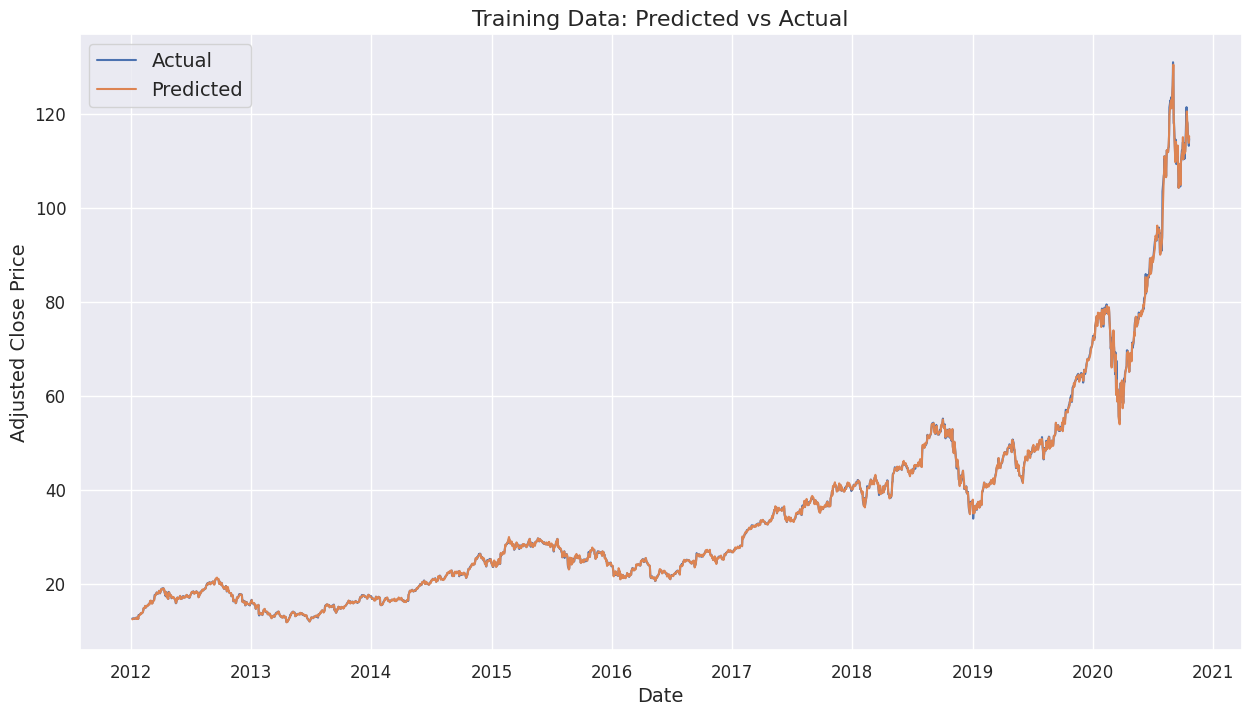

In [103]:
# Step 8: Plot Predicted vs Actual for Training Data
train_dt_preds1_pdf = dt_preds_train1.select('Date', 'prediction', 'actual_adj_close').toPandas()
train_dt_preds1_pdf['Date'] = pd.to_datetime(train_dt_preds1_pdf['Date'])
train_dt_preds1_pdf.set_index('Date', inplace=True)

fig, ax = plt.subplots()
sns.lineplot(data=train_dt_preds1_pdf, x=train_dt_preds1_pdf.index, y='actual_adj_close', label="Actual")
sns.lineplot(data=train_dt_preds1_pdf, x=train_dt_preds1_pdf.index, y='prediction', label="Predicted")
ax.set_ylabel('Adjusted Close Price')
ax.set_xlabel('Date')
ax.set_title('Training Data: Predicted vs Actual')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
plt.show()

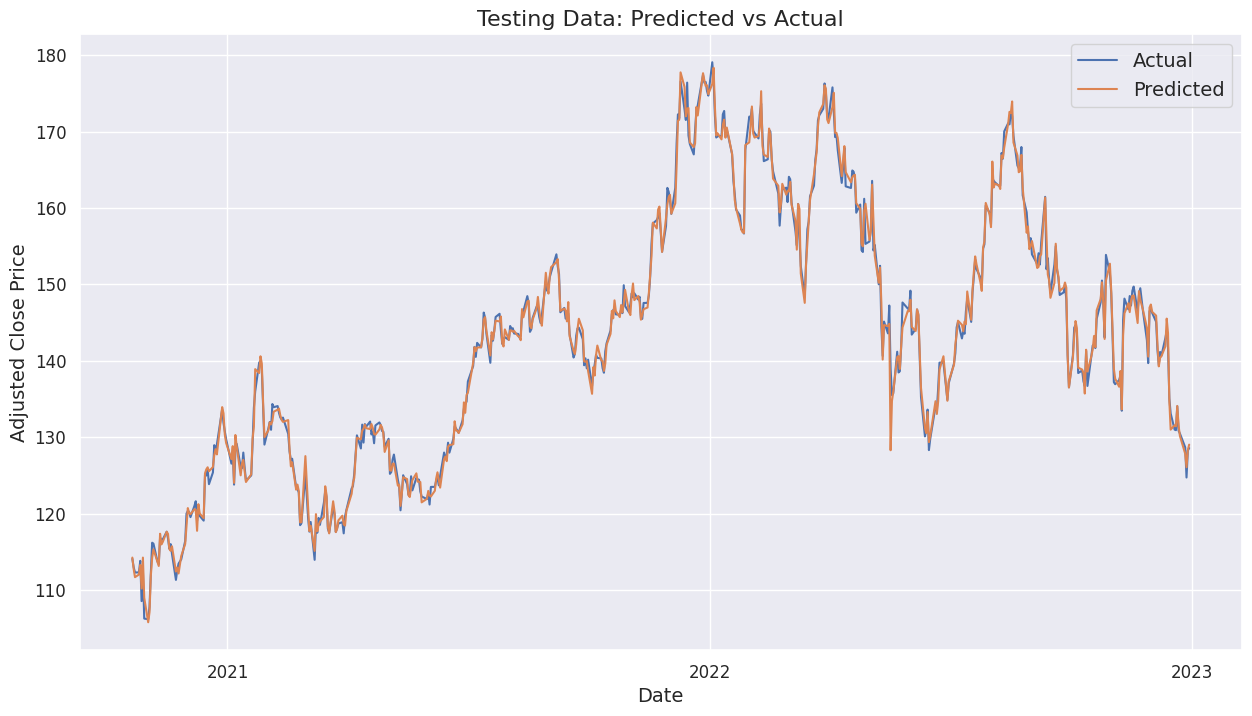

In [104]:
# Step 9: Plot Predicted vs Actual for Testing Data
test_dt_preds1_pdf = dt_preds_test1.select('Date', 'prediction', 'actual_adj_close').toPandas()
test_dt_preds1_pdf['Date'] = pd.to_datetime(test_dt_preds1_pdf['Date'])
test_dt_preds1_pdf.set_index('Date', inplace=True)

fig, ax = plt.subplots()
sns.lineplot(data=test_dt_preds1_pdf, x=test_dt_preds1_pdf.index, y='actual_adj_close', label="Actual")
sns.lineplot(data=test_dt_preds1_pdf, x=test_dt_preds1_pdf.index, y='prediction', label="Predicted")
ax.set_ylabel('Adjusted Close Price')
ax.set_xlabel('Date')
ax.set_title('Testing Data: Predicted vs Actual')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
plt.show()

Gradient Boost

In [105]:
# Step 1: Prepare Training and Testing Data
train_df_gbt_1 = train_df1.withColumnRenamed("Log_Diff1", "label")
test_df_gbt_1 = test_df1.withColumnRenamed("Log_Diff1", "label")

# Step 2: Train the Gradient Boosted Trees Model
gbt = GBTRegressor(featuresCol="features", labelCol="label", maxIter=50)
gbt_model = gbt.fit(train_df_gbt_1)

# Step 3: Generate Predictions
gbt_preds_train1 = gbt_model.transform(train_df_gbt_1)
gbt_preds_test1 = gbt_model.transform(test_df_gbt_1)

# Step 4: Convert Predictions Back to Original Scale for Training Data
gbt_preds_train1 = (
    gbt_preds_train1
    .withColumnRenamed("label", "Log_Diff1")
    .withColumnRenamed("prediction", "Log_Diff_Prediction")
    .withColumn("predicted_adj_close", f.exp(f.col("Lag_1")) * f.exp(f.col("Log_Diff_Prediction")))
    .withColumnRenamed("Adj Close", "actual_adj_close")
    .withColumnRenamed("predicted_adj_close", "prediction")
)

# Step 5: Convert Predictions Back to Original Scale for Testing Data
gbt_preds_test1 = (
    gbt_preds_test1
    .withColumnRenamed("label", "Log_Diff1")
    .withColumnRenamed("prediction", "Log_Diff_Prediction")
    .withColumn("predicted_adj_close", f.exp(f.col("Lag_1")) * f.exp(f.col("Log_Diff_Prediction")))
    .withColumnRenamed("Adj Close", "actual_adj_close")
    .withColumnRenamed("predicted_adj_close", "prediction")
)

# Step 6: Collect Actual and Predicted Values for Evaluation
A_trt_gbt1 = np.array(gbt_preds_train1.select('actual_adj_close').rdd.map(lambda row: row[0]).collect())
P_trt_gbt1 = np.array(gbt_preds_train1.select('prediction').rdd.map(lambda row: row[0]).collect())
A_tet_gbt1 = np.array(gbt_preds_test1.select('actual_adj_close').rdd.map(lambda row: row[0]).collect())
P_tet_gbt1 = np.array(gbt_preds_test1.select('prediction').rdd.map(lambda row: row[0]).collect())

# Step 7: Evaluate the Model
train_rmse_gbt = np.sqrt(np.mean((A_trt_gbt1 - P_trt_gbt1) ** 2))
test_rmse_gbt = np.sqrt(np.mean((A_tet_gbt1 - P_tet_gbt1) ** 2))

def smape(actual, predicted):
    return 100 * np.mean(2 * np.abs(predicted - actual) / (np.abs(predicted) + np.abs(actual)))

train_smape_gbt = smape(A_trt_gbt1, P_trt_gbt1)
test_smape_gbt = smape(A_tet_gbt1, P_tet_gbt1)

print("GBT Model on 1-Day RMSE on Training Data = %g" % train_rmse_gbt)
print("GBT Model on 1-Day RMSE on Testing Data = %g" % test_rmse_gbt)
print("GBT Model on 1-Day sMAPE on Training Data = %g" % train_smape_gbt)
print("GBT Model on 1-Day sMAPE on Testing Data = %g" % test_smape_gbt)



GBT Model on 1-Day RMSE on Training Data = 0.0551427
GBT Model on 1-Day RMSE on Testing Data = 0.707224
GBT Model on 1-Day sMAPE on Training Data = 0.0884244
GBT Model on 1-Day sMAPE on Testing Data = 0.210603


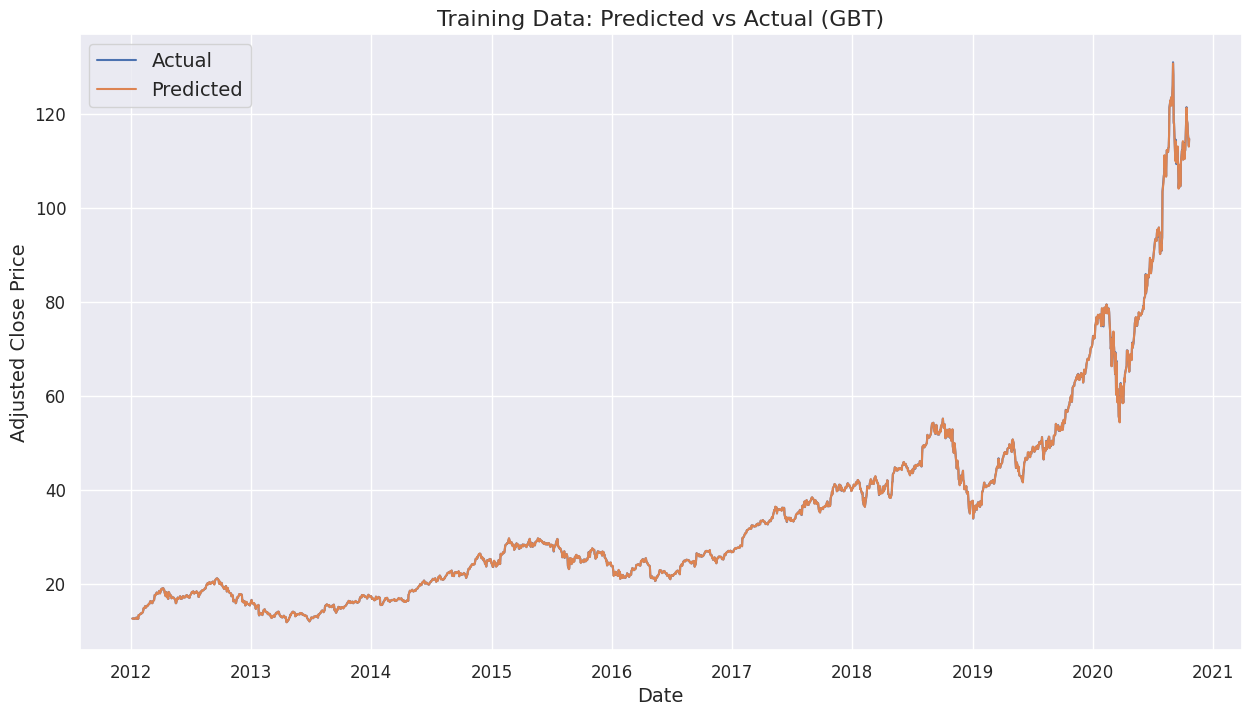

In [106]:
# Step 8: Plot Predicted vs Actual for Training Data
train_gbt_preds1_pdf = gbt_preds_train1.select('Date', 'prediction', 'actual_adj_close').toPandas()
train_gbt_preds1_pdf['Date'] = pd.to_datetime(train_gbt_preds1_pdf['Date'])
train_gbt_preds1_pdf.set_index('Date', inplace=True)

fig, ax = plt.subplots()
sns.lineplot(data=train_gbt_preds1_pdf, x=train_gbt_preds1_pdf.index, y='actual_adj_close', label="Actual")
sns.lineplot(data=train_gbt_preds1_pdf, x=train_gbt_preds1_pdf.index, y='prediction', label="Predicted")
ax.set_ylabel('Adjusted Close Price')
ax.set_xlabel('Date')
ax.set_title('Training Data: Predicted vs Actual (GBT)')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
plt.show()

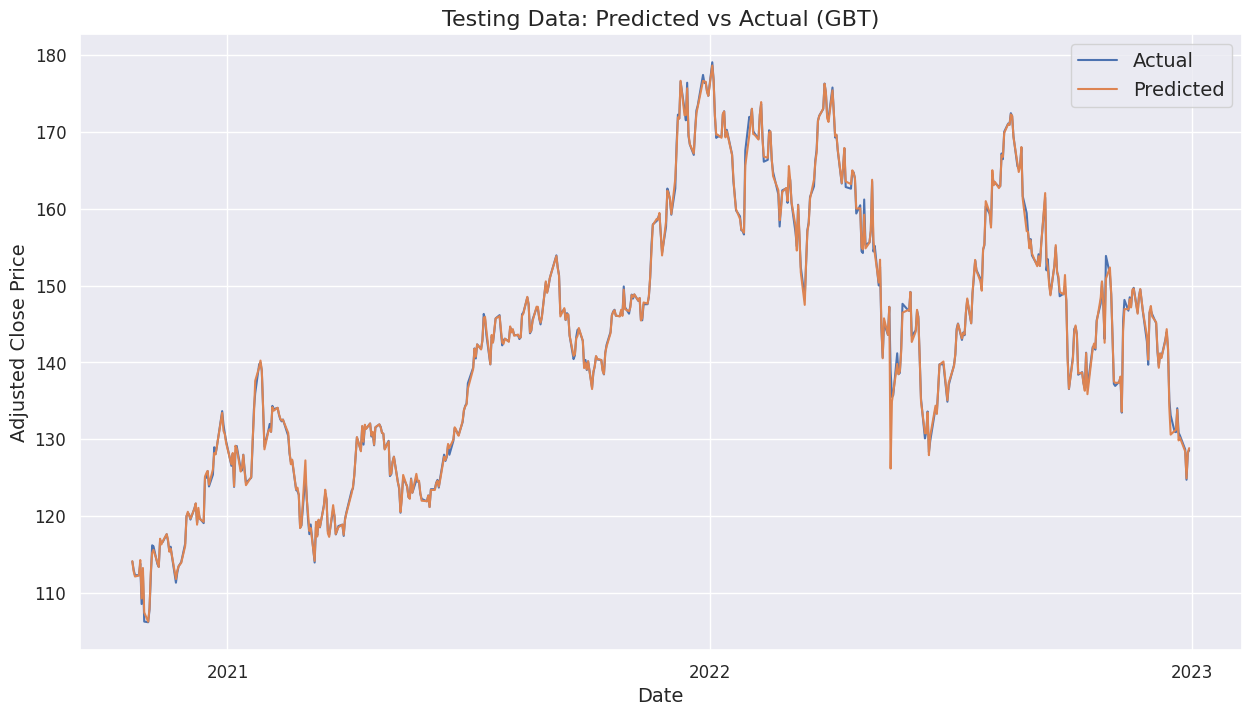

In [107]:
# Step 9: Plot Predicted vs Actual for Testing Data
test_gbt_preds1_pdf = gbt_preds_test1.select('Date', 'prediction', 'actual_adj_close').toPandas()
test_gbt_preds1_pdf['Date'] = pd.to_datetime(test_gbt_preds1_pdf['Date'])
test_gbt_preds1_pdf.set_index('Date', inplace=True)

fig, ax = plt.subplots()
sns.lineplot(data=test_gbt_preds1_pdf, x=test_gbt_preds1_pdf.index, y='actual_adj_close', label="Actual")
sns.lineplot(data=test_gbt_preds1_pdf, x=test_gbt_preds1_pdf.index, y='prediction', label="Predicted")
ax.set_ylabel('Adjusted Close Price')
ax.set_xlabel('Date')
ax.set_title('Testing Data: Predicted vs Actual (GBT)')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
plt.show()